In [1]:
#imports
import numpy as np
import numpy.random as rd
import numpy.linalg as linalg
import math
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from hmmlearn import hmm

In [2]:
def sample(prob): # BS can be done
    r = rd.random();i = 0
    while r > prob[i]:
        r-=prob[i]
        i+=1
    return i

def bernoulli(prob):
    if rd.random() > prob:
        return 1.0
    return 0.0

def row_normalize(arr):
    arr = np.array(arr,float)
    for i in range(np.shape(arr)[0]):
        arr[i] = arr[i]/np.sum(arr[i])
    return arr

def dot(x,y):
    return np.sum(np.multiply(x,y))

def steady_state_prob(matrix):
    """
    This function calculates relative throughput from a probability matrix
    :param matrix: the probability matrix
    :return: A list of relative throughput values
    """
    a_list = []
    b_list = []
    for v in matrix:
        a_list.append(1)
        b_list.append(0)
    b_list.append(1)
    A = np.append(np.transpose(matrix) - np.identity(len(matrix)), [a_list], axis=0)
    b = np.transpose(np.array(b_list))
    return np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

In [3]:
en = 3
ch = 3
P = np.array([[.1, .2, .7],[.5, .3, .2],[.3, .3, .4]])
E = np.array([[.5,.6,.4],[.2,.3,.1],[.4,.5,.3]])
# E = np.array([[.6,.9,.3],[.3,.5,.1],[.4,.1,.05]])
R = np.array([8.,6.,4.])
# P = row_normalize([np.random.rand(ch)/2])[0]
# E = np.random.rand(en,ch)/2
# R = np.array([np.random.randint(1,10) for i in range(en)])
tol = .3
print(P)
print(E)
print(R)

[[0.1 0.2 0.7]
 [0.5 0.3 0.2]
 [0.3 0.3 0.4]]
[[0.5 0.6 0.4]
 [0.2 0.3 0.1]
 [0.4 0.5 0.3]]
[8. 6. 4.]


In [4]:
ub = np.sum(E*steady_state_prob(P),axis=1)
ltemp = linprog(c = -1*R, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='simplex')
print(min(ub))
print(dot(ltemp.x,R), np.sum(ltemp.x),ltemp.con, ltemp.success, dot(ltemp.x,ub))
org_x = ltemp.x
print(ltemp.x)

0.18360655737704915
6.775956284153006 1.0 [0.] True 0.3
[0.38797814 0.61202186 0.        ]


In [5]:
print(en,ch,tol,np.dot(ltemp.x,R),min(ub))
print(P)
print(E)
print(ltemp.x)

3 3 0.3 6.775956284153006 0.18360655737704915
[[0.1 0.2 0.7]
 [0.5 0.3 0.2]
 [0.3 0.3 0.4]]
[[0.5 0.6 0.4]
 [0.2 0.3 0.1]
 [0.4 0.5 0.3]]
[0.38797814 0.61202186 0.        ]


In [6]:
# finding safe x0
ub = E.transpose();tol_arr = [tol]*ch
ltemp = linprog(c=np.zeros(en),A_ub = ub,b_ub=tol_arr,A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-3})
x0 = np.transpose(row_normalize([ltemp.x+(0.0)])) # noise to safe to avoid singular matrices, 1.0e-2 is working
norm_x0 = linalg.norm(x0)
e0 = x0/norm_x0 # safe vector
e0_trans = e0.transpose()
en0 = sample(x0.transpose()[0])
b0 = bernoulli(E[en0][sample(steady_state_prob(P))])
yt = (E[en0]*(1-b0))+((1-E[en0])*b0)
yt = row_normalize([np.exp(yt)]).transpose()
c0 = dot(x0,np.matmul(E,yt)) # safe cost
print(x0.flatten(),c0)

[0. 1. 0.] 0.2066555795755198


In [7]:
# parameters
reg = 0.1 # lambda > 0, regualarization param
conf = 0.1 # delta >= 0, <= 1, confidence prob -> with 1-del prob tolerance holds
alfa_c = 0.001 # >= 1, ellipse radii, best : 0.001
Sa = 1.;La = 1.;Ra = 1. # assumption parameters
R_sum = np.sum(R)
Rn_trans = R/R_sum
Rn = np.transpose([Rn_trans])
# x = [np.transpose(row_normalize([np.ones(en)]))]
x = [x0]
r = [dot(x[-1],Rn)];c = [c0]
b = [0]; enc = [rd.randint(en)];chnl = [rd.randint(ch)]
avg_rate = []
# markov extra param
p = []
# p.append(row_normalize(np.random.rand(ch,ch)))
p.append(row_normalize(np.ones((ch,ch))))
step = 50
lr = 0.01
eps = .5
eps_min = 0.01

In [8]:
# algo
iop = np.identity(en) - (np.matmul(x0,x0.transpose())/pow(norm_x0,2.0))
sigopt = reg*iop; uopt = 0.0
rn = rd.rand()
sprob = steady_state_prob(p[-1])
for t in range(1,50000):
    enc.append(sample(x[-1].transpose()[0]))
    if rn < max(eps_min,eps/float(t+1)): # put as running eps
        enc.append(rd.randint(0,en))
    else:
        enc.append(sample(x[-1].transpose()[0]))
    chnl.append(sample(P[chnl[-1]]))
    b.append(int(bernoulli(E[enc[-1]][chnl[-1]])))
    if t%step == 0:
        # markov part
        model = hmm.MultinomialHMM(n_components=ch, params='t', init_params='',n_iter=100, tol=1.0e-2)
        model.startprob_ = sprob
        if rn < max(eps_min,eps/float(t+1)):
            step_emiss = np.sum(E,axis=0)/3
        else:
            step_emiss = np.sum(x[-1]*E,axis=0)
        model.emissionprob_ = [[step_emiss[i],1-step_emiss[i]] for i in range(ch)]
        model.transmat_ = np.copy(p[-1])
        model.fit([b[-1*step:]]) #here
        temp = np.copy(p[-1])
        lr = min(lr,1.0/float(t+1)) # adaptive learning rate
        temp = temp + lr*(model.transmat_-temp) # progressive update
        temp = row_normalize(temp)
        p.append(temp)
        sprob = steady_state_prob(p[-1])
        # OPLB
        r.append(dot(x[-1],Rn))
        c.append(np.max([dot(x[-1].transpose(),i) for i in np.matmul(p[-1],E.transpose())]))
        copt = c[-1] - (dot(x[-1],e0)/norm_x0)*c[0]
        xopt = x[-1] - (dot(x[-1],e0)*e0)
        sigopt += np.matmul(xopt,xopt.transpose())
        uopt += (copt*xopt)
        muopt = np.matmul(linalg.pinv(sigopt),uopt) # (inverse is blowing up, singular matrices) so did pseudo(SVD)
        ub = ((c[0]/norm_x0)*e0_trans)+muopt.transpose()-(dot(e0,muopt)*e0_trans)
        betat = Ra*math.sqrt(en*math.log10((1+(t-1)*La*La/reg)/conf))+math.sqrt(reg)*Sa # used log10
        val = alfa_c*betat*linalg.norm(xopt)
        try:
            ltemp = linprog(c = -1*Rn_trans, A_ub = ub, b_ub = [tol-val],A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-2})
        except:
            print(t,'skipped')
            continue
        rn = rd.rand()
        x.append(np.transpose([ltemp.x]))
        avg_rate.append(dot(x[-1],Rn)*R_sum)
        print(t,avg_rate[-1],ltemp.success)
# print(copt)
# print(xopt)
# print(sigopt)
# print(uopt)
# print(muopt)
# print(ub,betat)

50 8.0 True
100 6.722579406411658 True
150 6.73143280471054 True
200 6.723086534496012 True
250 6.7167281066103905 True
300 6.711744543287267 True
350 6.707596621733085 True
400 6.704100068564405 True
450 6.701206546561324 True
500 6.698699175584943 True
550 6.696546129650313 True
600 6.6946598678037095 True
650 6.692995221145712 True
700 6.69151265206903 True
750 6.69013947169094 True
800 6.68892848244259 True
850 6.68782206919513 True
900 6.686795284250389 True
950 6.685852669319863 True
1000 6.684998125259945 True
1050 6.684208785906242 True
1100 6.683482814854356 True
1150 6.682807435204603 True
1200 6.682173996411191 True
1250 6.6815816337962 True
1300 6.6810397097378935 True
1350 6.680532280906743 True
1400 6.680054866920692 True
1450 6.6796171895772645 True
1500 6.679206319594057 True
1550 6.678817516859479 True
1600 6.678451589883681 True
1650 6.678103430478955 True
1700 6.677771459079804 True
1750 6.67746112526736 True
1800 6.677165496415322 True
1850 6.676886204662519 True
19

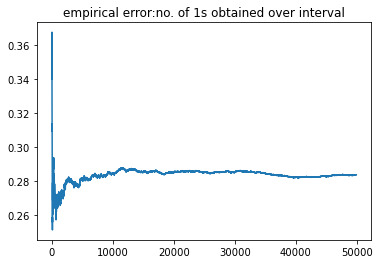

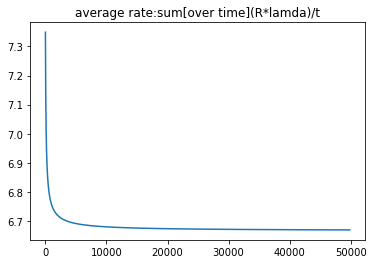

In [9]:
stat = 100
error_plot = 1.0 - np.copy(b)
for i in range(1,len(error_plot)):
    error_plot[i] += (error_plot[i-1]*(i-1))
    error_plot[i] =error_plot[i]/i
plt.plot(error_plot[stat:])
plt.title('empirical error:no. of 1s obtained over interval')
plt.show()
rate_plot = []
for i in avg_rate:
    rate_plot.extend([i]*step)
for i in range(1,len(rate_plot)):
    rate_plot[i] += (rate_plot[i-1]*(i-1))
    rate_plot[i] =rate_plot[i]/i
plt.plot(rate_plot[stat:])
plt.title('average rate:sum[over time](R*lamda)/t')
plt.show()

In [10]:
print(x0.flatten())
print(x[-1].flatten(),error_plot[-1],rate_plot[-1])
print(org_x,tol,dot(org_x,R))

[0. 1. 0.]
[0.33352322 0.66647678 0.        ] 0.28370567411347825 6.669824527559324
[0.38797814 0.61202186 0.        ] 0.3 6.775956284153006


16.574992465918786


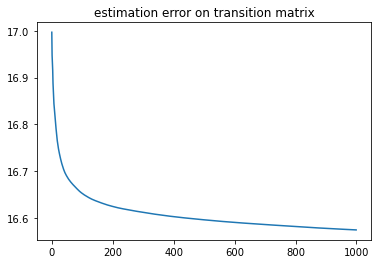

In [11]:
err = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in range(len(p)):
    err.append(np.sqrt(np.sum(np.square(P-p[i]))/s)*100)
    err[i] += (err[i-1]*(i))
    err[i] = err[i]/(i+1)
print(err[-1])
plt.plot(err)
plt.title('estimation error on transition matrix')
plt.show()

[0.32677015 0.32576849 0.34746135]
[0.29508197 0.2704918  0.43442623]
6.30171319222722


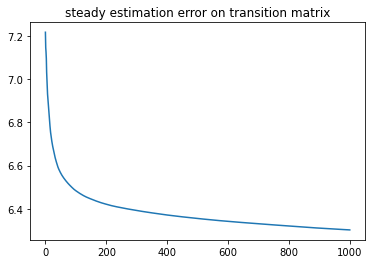

In [12]:
err = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in range(len(p)):
    err.append(np.sqrt(np.sum(np.square(steady_state_prob(P)-steady_state_prob(p[i])))/3)*100)
    err[i] += (err[i-1]*(i))
    err[i] = err[i]/(i+1)
print(steady_state_prob(p[-1]))
print(steady_state_prob(P))
print(err[-1])
plt.plot(err)
plt.title('steady estimation error on transition matrix')
plt.show() 

4.459012958322833


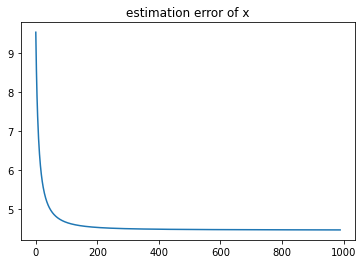

In [15]:
err = []; s = 3
for i in range(len(x)):
    err.append(np.sqrt(np.sum(np.square(org_x-x[i].flatten()))/s)*100)
    err[i] += (err[i-1]*(i))
    err[i] = err[i]/(i+1)
print(err[-1])
plt.plot(err[10:])
plt.title('estimation error of x')
plt.show()

In [57]:
# Rough

In [ ]:
(Ra*math.sqrt(en*math.log10((1+(t-1)*La*La/.1)/0.9))+math.sqrt(.1)*Sa)*linalg.norm(xopt) 

In [ ]:
alfa_c -> lamda error %
0.0 -> 0.7263980978187543
0.0001 -> 0.64
0.001 -> 0.17
0.005 -> 4